In [ ]:
#Mounts your google drive into this virtual machine

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install mne

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,corrmap)
from sklearn.cross_decomposition import CCA
from scipy.signal import butter, lfilter, periodogram
from scipy.fft import fft, fftfreq, ifft
import scipy.io as sio

# **Alpha EEG Analysis**

Creating RawArray with float64 data, n_channels=10, n_times=12810
    Range : 0 ... 12809 =      0.000 ...    51.236 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 413 samples (1.652 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper trans

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


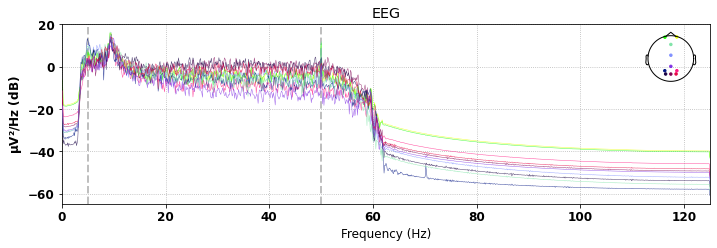

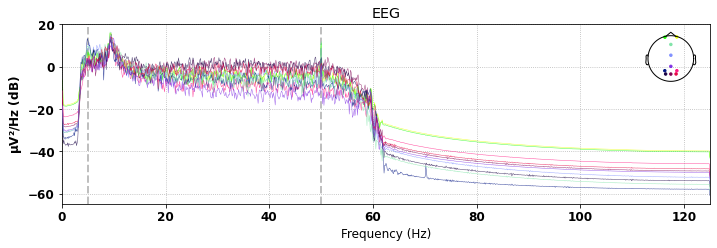

In [ ]:
data_path = '/content/drive/MyDrive/YOURPATH/SharedPublicly/Data/Alpha_RAW_1710_092421.mat'
Alpha_mat = sio.loadmat(data_path)

## Loading and preprocessing data ##
timestamps = Alpha_mat['Alpha_continuous_timestamps'][0]
eeg_data = Alpha_mat['Alpha_continuous'][:,-10:].T/(10**6)

chan_names = ['Fp1', 'Fp2', 'Fz', 'Cz', 'Pz', 'Oz', 'PO3', 'PO4', 'O1', 'O2']
ch_types = ['eeg'] * len(chan_names)
custom_montage = mne.channels.make_standard_montage('standard_1005')

sfreq = 250
info = mne.create_info(ch_names=chan_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage(custom_montage)
raw = mne.io.RawArray(eeg_data, info)
raw.filter(5,50)
raw.notch_filter(np.arange(60, 125, 60))
raw.set_montage(custom_montage)
raw.set_eeg_reference(ref_channels='average')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)
raw.plot_psd(show=False)

In [ ]:
#Creating eyes open and eyes closed epochs

marker_stamps = Alpha_mat['Marker_timestamps'].flatten()
marker_names = Alpha_mat['Marker_samples'].flatten().astype(int).astype(str)
choose_marker = {f'{n}':i for i,n in enumerate(np.unique(marker_names))}
marker_labels = [choose_marker[i] for i in marker_names]

#Create events array
events = np.zeros((1,3),dtype=np.int64) #int64?
start_time = timestamps[0]*sfreq #Get start index
eeg_stamps = timestamps

for i in range(len(marker_stamps)):
    mark_t = marker_stamps[i] #Get the time stamps of marker number i
    print(mark_t)
    epoch_bool = np.where(eeg_stamps > mark_t,True,False)
    idx_time = timestamps[epoch_bool][0].item()*sfreq #Get index where current time-stamp occurs
    marker_label = marker_labels[i]
    new_event = np.array([round(idx_time-start_time),0,int(marker_label)]) #Make array of (idx at event,0,marker_label)
    events = np.vstack((events,new_event))
events = events[1:]

tmax = 10.
tmin = -0.1
picks = list(range(0,10))
raw_epochs = mne.Epochs(raw,events,event_id=choose_marker,picks=picks,tmin=tmin,tmax=tmax) #Specify picks to select specific channels

Loading data for 2 events and 2526 original time points ...
0 bad epochs dropped
Effective window size : 1.024 (s)
Loading data for 2 events and 2526 original time points ...
0 bad epochs dropped
Effective window size : 1.024 (s)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


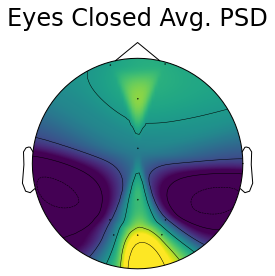

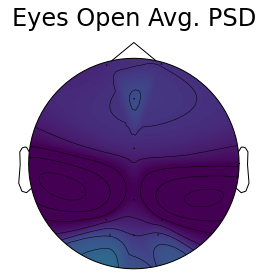

(<matplotlib.image.AxesImage at 0x7f7b03f9f810>,
 <matplotlib.contour.QuadContourSet at 0x7f7b03f9f0d0>)

In [ ]:
psds_open,freq = mne.time_frequency.psd_welch(raw_epochs['0'],fmin=10, fmax=12)
psds_close,freq = mne.time_frequency.psd_welch(raw_epochs['1'],fmin=10, fmax=12)
avg_psds_close = np.mean(np.mean(psds_close,axis=0),axis=1)
avg_psds_open = np.mean(np.mean(psds_open,axis=0),axis=1)

font = {'family' : 'normal',
#         'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)
min_psd = np.min(np.concatenate((avg_psds_open,avg_psds_close)))
max_psd = np.max(np.concatenate((avg_psds_open,avg_psds_close)))
plt.title("Eyes Closed Avg. PSD")
mne.viz.plot_topomap(avg_psds_close,info,
                     vmin=min_psd,vmax=max_psd,names=chan_names,
                    cmap="viridis")
plt.title("Eyes Open Avg. PSD")
mne.viz.plot_topomap(avg_psds_open,info,
                     vmin=min_psd,vmax=max_psd,names=chan_names,
                    cmap="viridis")